In [ ]:
!pip install -q keras-tcn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 10.8 MB/s eta 0:00:00


In [ ]:
!pip install -q wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.5/206.5 kB 20.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.6 MB/s eta 0:00:00


In [ ]:
!pip install -q pyproj

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 60.7 MB/s eta 0:00:00


In [ ]:
import sys
sys.path.insert(0,'/content/drive/Othercomputers/My Laptop/github-repositories/wavenet-trajectory/')  #Root folder
sys.path.insert(0,'/content/drive/Othercomputers/My Laptop/github-repositories/wavenet-trajectory/utils') # Libraries folder

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pickle as pkl

from utils import map_vis_without_lanelet

from tcn import TCN, tcn_full_summary

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# EXPERIMENT PARAMETERS
in_timesteps = 8
out_timesteps = 12
in_features = 5   # x,y,vx,vy,yaw
out_features = 2  # x,y

meta_features = 2 # "object_id","cluster_id"

total_features = in_features + meta_features # we need to keep object_id features and other identifiers
total_timesteps = in_timesteps + out_timesteps

# Project name
wandb_project_name = "wavenet-trajectory"

full_train_dataset_path = "/content/drive/Othercomputers/My Laptop/github-repositories/wavenet-trajectory/data/DR_USA_Intersection_MA/_train.csv"
full_test_dataset_path = "/content/drive/Othercomputers/My Laptop/github-repositories/wavenet-trajectory/data/DR_USA_Intersection_MA/_val.csv"

train_dataset_path = "/content/drive/Othercomputers/My Laptop/github-repositories/wavenet-trajectory/data/DR_USA_Intersection_MA/_train_split-{0}.csv"
test_dataset_path = '/content/drive/Othercomputers/My Laptop/github-repositories/wavenet-trajectory/data/DR_USA_Intersection_MA/_test_split-{0}.csv'

scaler_x_path = '/content/drive/Othercomputers/My Laptop/github-repositories/wavenet-trajectory/models/wavenet/scaler_x.pkl'
scaler_y_path = '/content/drive/Othercomputers/My Laptop/github-repositories/wavenet-trajectory/models/wavenet/scaler_y.pkl'

model_save_path = '/content/drive/Othercomputers/My Laptop/github-repositories/wavenet-trajectory/models/wavenet-no-grid/'
model_reload_path = '/content/drive/Othercomputers/My Laptop/github-repositories/wavenet-trajectory/models/wavenet-no-grid/'

csv_out_path = '/content/drive/Othercomputers/My Laptop/github-repositories/wavenet-trajectory/models/wavenet-no-grid/'
results_pkl_path = '/content/drive/Othercomputers/My Laptop/github-repositories/wavenet-trajectory/models/wavenet-no-grid/'

map_path = "/content/drive/Othercomputers/My Laptop/github-repositories/wavenet-trajectory/data/maps/DR_USA_Intersection_MA.osm"




**METRICS**

In [ ]:
# ADE function (single)

import math
def average_displacement_error(pred,ground):

    e = []

    for p,g in zip(pred,ground):
        e.append( math.sqrt (((p[0] - g[0]) ** 2) + ((p[1] - g[1]) ** 2)))

    return np.sum(e)/len(e),e[len(e)-1]   #ADE,FDE

# ADE function over BATCH (mean)

def calculate_error_batch(results, ground):

    ade = []
    fde = []

    for r, g in zip(results, ground):
        a,f = average_displacement_error(r,g)
        ade.append(a)
        fde.append(f)

    return np.sum(ade)/len(ade), np.sum(fde)/len(fde)


In [ ]:
def scale_3D_array(x, scaler_path, scaler_reload = True, inverse_transform = False, scaler_type=MinMaxScaler()):

    shape = x.shape

    x = x.reshape(-1, shape[2])

    features = x[:,meta_features:]
    meta = x[:,0:meta_features]

    if scaler_reload is True: # if this is test set
        scaler = pd.read_pickle(scaler_path)
    else:
        scaler = scaler_type

    if inverse_transform is True:
        features = scaler.inverse_transform(features)
    else:
        features = scaler.fit_transform(features)

    x  = np.concatenate((meta,features),axis=1)
    x = x.reshape(shape[0],shape[1],shape[2])

    if scaler_reload is False:  # if this is training set save scaler to file
        # Save scaler to file
        with open(scaler_path, "wb") as outfile:
            pkl.dump(scaler, outfile)

    return x

In [ ]:
def load_data(dataset_path):
    # Load clustered dataset
    #dataframe = pd.read_csv(dataset_path[0], sep=',')

    # Concatenate multiples dataset
    dataframe = pd.concat((pd.read_csv(f) for f in dataset_path), ignore_index=True)

    # Works if all trajectories have the same length and each cluster has the same number of vehicles
    # Convert from 2D to 3D representation (3D for LSTM)
    dataframe_numpy = dataframe.to_numpy().reshape(-1,total_timesteps,total_features)

    # Split the ground truth and the input
    x_train =  dataframe_numpy[:,0:8,:]
    y_train  = dataframe_numpy[:,8:,:]

    return x_train, y_train, dataframe

In [ ]:
def write_results(x,r,file_name="results.csv",columns=['case_id','object_id','cluster_id','x','y','vx','vy','psi_rad']):
    trajectories = np.concatenate((x,r),axis=1)
    trajectories = trajectories.reshape(-1,trajectories.shape[2])

    df = pd.DataFrame(data = trajectories, columns = columns)

    df.case_id = df.case_id.astype('int64')
    df.object_id = df.object_id.astype('int64')
    df.cluster_id = df.cluster_id.astype('int64')

    # Dummy values
    df['vx'] = 0
    df['vy'] = 0
    df['psi_rad'] = 0

    df_xy = df  # Return the dataframe with zeroes in vx,vy,psi_rad, required by print functions

    # write only x,y features to output file
    df_xy.drop(columns=['vx','vy','psi_rad'], inplace=True)
    df_xy.to_csv(csv_out_path + file_name,  index = False)

    return df

In [ ]:
import wandb
from wandb.keras import WandbCallback

wandb.init(project=wandb_project_name)

#wandb
wandb_callback = WandbCallback(monitor='val_loss', mode='min', log_gradients=False,save_model=False)

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


**START**

In [ ]:
# Load all train data for scaler calculations
full_x_train, full_y_train, full_dataset  = load_data([full_train_dataset_path])
full_x_train_scaled = scale_3D_array(full_x_train, scaler_x_path, scaler_reload = False, scaler_type=MinMaxScaler()) # don't reload the scaler from file
full_y_train_scaled = scale_3D_array(full_y_train, scaler_y_path, scaler_reload = False, scaler_type=MinMaxScaler())

In [ ]:
# Load clustered dataset and split the ground truth and the input (TRAIN)
x_train, y_train, dataset  = load_data([train_dataset_path.format(0),train_dataset_path.format(1),train_dataset_path.format(2)])

x_train_scaled = scale_3D_array(x_train, scaler_x_path, scaler_reload = True, scaler_type=MinMaxScaler())
y_train_scaled = scale_3D_array(y_train, scaler_y_path, scaler_reload = True, scaler_type=MinMaxScaler())

In [ ]:
# Load clustered dataset and split the ground truth and the input (VALIDATION)
x_validation, y_validation, dataset_validation  = load_data([train_dataset_path.format(8),train_dataset_path.format(9)]) #20% for validation

x_validation_scaled = scale_3D_array(x_validation, scaler_x_path, scaler_reload = True, scaler_type=MinMaxScaler())
y_validation_scaled = scale_3D_array(y_validation, scaler_y_path, scaler_reload = True, scaler_type=MinMaxScaler())

In [ ]:
# Reverse normalization, test if normalization functions works ok
#a = scale_3D_array(x_train_scaled, scaler_x_path, inverse_transform = True)
#b = scale_3D_array(y_train_scaled, scaler_y_path, inverse_transform = True)

#print(np.allclose(b,y_train))

In [ ]:
#from sklearn.utils import shuffle
# Shuffle the dataset, but only on the first axis
#x_train_scaled, y_train_scaled = shuffle(x_train_scaled, y_train_scaled, random_state=1)

In [ ]:
def print_trajectory_set(in_seq,gt_seq,result_seq, start, show_map = False, zoom_map = True, debug=None):

    fig, ax = plt.subplots(3,3,figsize=(40,5))
    fig.set_size_inches(50, 50)

    index = start

    for i in range(0,3):
        for j in range(0,3):
            ax[i, j] = print_trajectory(in_seq, gt_seq, result_seq, index, show_map = show_map, zoom_map = zoom_map, debug=debug, ax=ax[i,j])
            index = index + 1

    plt.show()

def print_trajectory_cluster(df,cluster_id, cluster_size=3, show_map = False, zoom_map = True, debug=None):

#    in_seq_2D = in_seq.reshape(-1,8)

#    columns = ["case_id","object_id","cluster_id","x","y","vx","vy","yaw"]
#    df = pd.DataFrame(data=in_seq_2D, columns=columns)

    clusters = df.groupby(["cluster_id"])

    cluster = clusters.get_group(cluster_id)
    cars = cluster.groupby(["object_id"])

    print(cars.groups.keys())

    fig, ax = plt.subplots(cluster_size,figsize=(40,5))
    fig.set_size_inches(8, 8)

    j = 0

    for id in cars.groups.keys():
        ax[j] = print_trajectory_by_id(df, id, show_map = show_map, zoom_map = zoom_map, debug=debug, ax=ax[j])
        j = j + 1
    plt.show()


def print_trajectory_by_id(df,id,show_map=False, zoom_map=True, debug=None,ax=None):

    car = df.loc[ df['object_id'] == id]
    car = car.to_numpy()
    car = np.expand_dims(car, axis=0)

    print_trajectory(car,car,car,0,show_map=show_map, zoom_map=zoom_map, debug=debug, ax=ax)


def print_trajectory(in_seq, gt_seq, result_seq, i, show_map = False, zoom_map = True, debug=None, ax=None):

    if(ax is None):
        fig, ax = plt.subplots(figsize=(160,20))  #40,5

#    case_id = in_seq[i,0,0] # get cluster_id
    object_id = in_seq[i,0,1]  # get object_id
    cluster_id = in_seq[i,0,2] # get cluster_id


    in_seq = in_seq[i,:,meta_features:meta_features+2]
    in_seq = np.squeeze(in_seq)
    in_seq_x = in_seq[:,0]
    in_seq_y = in_seq[:,1]

    gt_seq = gt_seq[i,:,meta_features:meta_features+2]
    gt_seq = np.squeeze(gt_seq)
    gt_seq_x = gt_seq[:,0]
    gt_seq_y = gt_seq[:,1]

    # x_coord and y_coord will be useful to calculate limit range of the map
    x_coord = np.concatenate((in_seq_x,gt_seq_x),axis=0) # join all xs
    y_coord = np.concatenate((in_seq_y,gt_seq_y),axis=0) # join all ys


    if (debug):
        print("input:\n",in_seq)
        print("truth:\n", gt_seq)

    ax.set_aspect('equal')

    # Display map using library provided without lanelet lib
    if (show_map == True):
        map_vis_without_lanelet.draw_map_without_lanelet(map_path, ax, 0.0, 0.0)

    ax.plot(in_seq_x, in_seq_y, '-o', color='gray',linewidth=1,zorder=100)
    ax.plot(gt_seq_x, gt_seq_y, '-o', color='goldenrod',linewidth=1,zorder=100)

    # Show detailed ticks in axis
    #x_ticks = np.array([ (i*5)+945 for i in range (0,36)])
    #y_ticks = np.array([ (i*5)+955 for i in range (0,21)])
    #plt.xticks(x_ticks)
    #plt.yticks(y_ticks)


    if(result_seq is not None):
        result_seq = result_seq[i,:, meta_features:meta_features+2] # meta_features:meta_features+2 = position of x,y features
        result_seq = np.squeeze(result_seq)
        result_seq_x = result_seq[:,0]
        result_seq_y = result_seq[:,1]

        if(debug):
            print("forecasted:\n", result_seq)

        ax.plot(result_seq_x, result_seq_y,'-o',color='red', linewidth=1, zorder=100)
        print("object[",object_id ,"] ADE(m), FDE(m): ", average_displacement_error(result_seq,gt_seq)) # Difference between predicted and ground truth

        # Join the r results to have a true zoom range
        x_coord = np.concatenate((x_coord,result_seq_x),axis=0) # join all xs
        y_coord = np.concatenate((y_coord,result_seq_y),axis=0) # join all ys
    else:
        # Print objects' id
        print("object[",object_id ,"]","cluster[",cluster_id,"]")



    # Limit the visible area of the plot
    if( zoom_map == True):

        # Calculate maxs and mins
        max_x = np.amax(x_coord)
        min_x = np.amin(x_coord)
        max_y = np.amax(y_coord)
        min_y = np.amin(y_coord)

        # Set limits
        ax.set_xlim([min_x -10 , max_x + 10])
        ax.set_ylim([min_y -10 , max_y + 10])

    if(ax is None):
        plt.show()

    return ax

In [ ]:
# Show  only a trajectoy by id
print_trajectory_by_id(dataset,78,show_map=False, zoom_map=True, debug=None, ax=None)

In [ ]:
# Show a complete cluster by id
print_trajectory_cluster(dataset,cluster_id= 2, cluster_size=3, show_map = True, zoom_map = True, debug=None)

In [ ]:
#print_trajectory_set(x_train[:,:,:], y_train[:,:,:],y_train[:,:,3:5],0,show_map=True, zoom_map=True,debug=False)
print_trajectory_set(x_train[:,:,:], y_train[:,:,:],None,0,show_map=True, zoom_map=True,debug=False)

object[ 174.0 ]


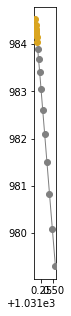

In [ ]:
#print_trajectory(x_train[:,:,:], y_train[:,:,:],y_train[:,:,3:5],0,show_map=False, zoom_map=False,debug=False)
_ = print_trajectory(x_train[:,:,:], y_train[:,:,:],None,0,show_map=False, zoom_map=False,debug=False)

In [ ]:
_ = print_trajectory(x_train[:,:,:], y_train[:,:,:],None,0,show_map=True, zoom_map=False,debug=False)

In [ ]:
import tensorflow as tf

input_layer = tf.keras.Input(shape=(in_timesteps,in_features)) # in_seq_len = 10, in_features = 5
tcn_layer = TCN(nb_filters=30, return_sequences=True, dilations=[1, 2, 4], kernel_size=3, use_skip_connections=True, use_layer_norm=True,  dropout_rate=0.2)(input_layer)
tcn_layer_2 = TCN(nb_filters=30, return_sequences=True, dilations=[1, 2, 4], kernel_size=3, use_skip_connections=True, use_layer_norm=True, dropout_rate=0.2)(tcn_layer)
tcn_layer_3 = TCN(nb_filters=30, return_sequences=True, dilations=[1, 2, 4], kernel_size=3, use_skip_connections=True, use_layer_norm=True, dropout_rate=0.2)(tcn_layer_2)
tcn_layer_4 = TCN(nb_filters=30, return_sequences=False, dilations=[1, 2, 4], kernel_size=3, use_skip_connections=True, use_layer_norm=True, dropout_rate=0.2)(tcn_layer_3)

repeat_layer = tf.keras.layers.RepeatVector(out_timesteps)(tcn_layer_4)
#decoder = TCN(nb_filters=512, return_sequences=True, dilations=[1, 2, 4, 8, 16, 32], kernel_size=3, use_skip_connections=True)(repeat_layer)
#decoder_last = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(units=out_features, activation='relu'))(decoder) # units= 2 because we are only predicting x,y

decoder_last = tf.keras.layers.Dense(out_features)(repeat_layer)


#encoder = tf.keras.layers.LSTM(512, return_sequences=False)(input_layer)
#latent_vector = tf.keras.layers.RepeatVector(10)(encoder)  #  RepeatVector = 10 = out_timesteps  !Attention
#decoder = tf.keras.layers.LSTM(512, return_sequences=True)(latent_vector)
#decoder_last = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(units=out_features, activation='relu'))(decoder) # units= 2 because we are only predicting x,y

model = tf.keras.Model(input_layer, decoder_last)

model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['mse', 'mae']) #0.00003

#uncomment this line to show model summary
#print(model.summary())

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 8, 5)]            0         
                                                                 
 tcn (TCN)                   (None, 8, 30)             14670     
                                                                 
 tcn_1 (TCN)                 (None, 8, 30)             16740     
                                                                 
 tcn_2 (TCN)                 (None, 8, 30)             16740     
                                                                 
 tcn_3 (TCN)                 (None, 30)                16740     
                                                                 
 repeat_vector (RepeatVector  (None, 12, 30)           0         
 )                                                               
                                                             

In [ ]:
#tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='logs_tcn', histogram_freq=1, write_images=True)
#%load_ext tensorboard
#%tensorboard --logdir logs_tcn

In [ ]:
# !!!IMPORTANT!!! only uncomment and run this line to load a pre-trained model file for re-training or evaluating
#model = tf.keras.models.load_model(model_reload_path)

In [ ]:
import os

class CustomSaver(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if epoch % 50 == 0:  # or save after some epoch, each k-th epoch etc.
            #self.model.save("model_{}.hd5".format(epoch))
            #self.model.save(model_save_path)
            path = os.path.join(model_save_path, "epoch-"+str(epoch))
            os.mkdir(path)
            self.model.save(path)

saver_callback = CustomSaver()

In [ ]:
# early stopping    #.00000000000001
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta = 0.000000000001, patience=5, mode='min', restore_best_weights=True) #0.00005
#saver_callback = tf.keras.callbacks.ModelCheckpoint(model_save_path, monitor='loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', save_freq=25)

# callbacks
#callbacks_list = [wandb_callback,early_stopping_callback,saver_callback]
callbacks_list = [wandb_callback,saver_callback]

In [ ]:
model = tf.keras.models.load_model("/content/drive/Othercomputers/My Laptop/github-repositories/wavenet-trajectory/models/wavenet-10d/epoch-600")

In [ ]:
# Model training
#from sklearn.utils import shuffle

model.fit(
    x_train_scaled[:,:,2:], y_train_scaled[:,:,2:4],
    batch_size = 128, #128
    epochs=2500,  #1000
    shuffle = True ,
    callbacks= callbacks_list,
    verbose = 2,
    validation_data = (x_validation_scaled[:,:,2:], y_validation_scaled[:,:,2:4])
)

Epoch 1/1000
95/95 [==============================] - ETA: 0s - loss: 0.0011 - mse: 0.0011 - mae: 0.0230

95/95 [==============================] - 47s 156ms/step - loss: 0.0011 - mse: 0.0011 - mae: 0.0230 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0221
Epoch 2/1000
95/95 [==============================] - 3s 37ms/step - loss: 0.0011 - mse: 0.0011 - mae: 0.0228 - val_loss: 0.0014 - val_mse: 0.0014 - val_mae: 0.0258
Epoch 3/1000
95/95 [==============================] - 3s 36ms/step - loss: 0.0011 - mse: 0.0011 - mae: 0.0229 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0236
Epoch 4/1000
95/95 [==============================] - 4s 37ms/step - loss: 0.0011 - mse: 0.0011 - mae: 0.0231 - val_loss: 0.0013 - val_mse: 0.0013 - val_mae: 0.0252
Epoch 5/1000
95/95 [==============================] - 3s 36ms/step - loss: 0.0011 - mse: 0.0011 - mae: 0.0228 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0218
Epoch 6/1000
95/95 [==============================] - 3s 37ms/step - loss: 0.0011 - mse: 0.0011 - mae: 0.0228 - val_loss: 0.0012 - val_mse: 0.0012 - val_mae: 0.0240
Epoch 7/1000
95/95 [=

95/95 [==============================] - 13s 139ms/step - loss: 0.0010 - mse: 0.0010 - mae: 0.0217 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0224
Epoch 32/1000
95/95 [==============================] - 3s 37ms/step - loss: 0.0010 - mse: 0.0010 - mae: 0.0217 - val_loss: 0.0013 - val_mse: 0.0013 - val_mae: 0.0261
Epoch 33/1000
95/95 [==============================] - 3s 37ms/step - loss: 0.0010 - mse: 0.0010 - mae: 0.0217 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0218
Epoch 34/1000
95/95 [==============================] - 3s 36ms/step - loss: 0.0010 - mse: 0.0010 - mae: 0.0217 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0222
Epoch 35/1000
95/95 [==============================] - 4s 37ms/step - loss: 0.0010 - mse: 0.0010 - mae: 0.0216 - val_loss: 0.0013 - val_mse: 0.0013 - val_mae: 0.0253
Epoch 36/1000
95/95 [==============================] - 3s 36ms/step - loss: 0.0010 - mse: 0.0010 - mae: 0.0216 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0227
Epoch 37/1000
95

95/95 [==============================] - 13s 133ms/step - loss: 9.6748e-04 - mse: 9.6748e-04 - mae: 0.0208 - val_loss: 0.0014 - val_mse: 0.0014 - val_mae: 0.0265
Epoch 62/1000
95/95 [==============================] - 4s 37ms/step - loss: 9.8160e-04 - mse: 9.8160e-04 - mae: 0.0209 - val_loss: 0.0013 - val_mse: 0.0013 - val_mae: 0.0245
Epoch 63/1000
95/95 [==============================] - 4s 38ms/step - loss: 9.7405e-04 - mse: 9.7405e-04 - mae: 0.0208 - val_loss: 0.0014 - val_mse: 0.0014 - val_mae: 0.0267
Epoch 64/1000
95/95 [==============================] - 4s 37ms/step - loss: 9.6285e-04 - mse: 9.6285e-04 - mae: 0.0207 - val_loss: 0.0012 - val_mse: 0.0012 - val_mae: 0.0240
Epoch 65/1000
95/95 [==============================] - 4s 38ms/step - loss: 9.6924e-04 - mse: 9.6924e-04 - mae: 0.0208 - val_loss: 0.0014 - val_mse: 0.0014 - val_mae: 0.0275
Epoch 66/1000
95/95 [==============================] - 3s 37ms/step - loss: 9.6810e-04 - mse: 9.6810e-04 - mae: 0.0208 - val_loss: 0.0013 - va

95/95 [==============================] - 13s 138ms/step - loss: 9.4011e-04 - mse: 9.4011e-04 - mae: 0.0203 - val_loss: 0.0017 - val_mse: 0.0017 - val_mae: 0.0300
Epoch 92/1000
95/95 [==============================] - 3s 37ms/step - loss: 9.5374e-04 - mse: 9.5374e-04 - mae: 0.0205 - val_loss: 0.0012 - val_mse: 0.0012 - val_mae: 0.0253
Epoch 93/1000
95/95 [==============================] - 4s 37ms/step - loss: 9.4789e-04 - mse: 9.4789e-04 - mae: 0.0204 - val_loss: 0.0013 - val_mse: 0.0013 - val_mae: 0.0250
Epoch 94/1000
95/95 [==============================] - 3s 36ms/step - loss: 9.3116e-04 - mse: 9.3116e-04 - mae: 0.0202 - val_loss: 0.0014 - val_mse: 0.0014 - val_mae: 0.0264
Epoch 95/1000
95/95 [==============================] - 3s 37ms/step - loss: 9.2077e-04 - mse: 9.2077e-04 - mae: 0.0200 - val_loss: 0.0013 - val_mse: 0.0013 - val_mae: 0.0259
Epoch 96/1000
95/95 [==============================] - 3s 36ms/step - loss: 9.2630e-04 - mse: 9.2630e-04 - mae: 0.0201 - val_loss: 0.0012 - va

95/95 [==============================] - 13s 136ms/step - loss: 9.0956e-04 - mse: 9.0956e-04 - mae: 0.0199 - val_loss: 0.0012 - val_mse: 0.0012 - val_mae: 0.0254
Epoch 122/1000
95/95 [==============================] - 3s 36ms/step - loss: 9.0870e-04 - mse: 9.0870e-04 - mae: 0.0198 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0226
Epoch 123/1000
95/95 [==============================] - 3s 32ms/step - loss: 9.0746e-04 - mse: 9.0746e-04 - mae: 0.0198 - val_loss: 0.0013 - val_mse: 0.0013 - val_mae: 0.0264
Epoch 124/1000
95/95 [==============================] - 3s 30ms/step - loss: 8.9980e-04 - mse: 8.9980e-04 - mae: 0.0197 - val_loss: 0.0014 - val_mse: 0.0014 - val_mae: 0.0271
Epoch 125/1000
95/95 [==============================] - 3s 30ms/step - loss: 8.9139e-04 - mse: 8.9139e-04 - mae: 0.0195 - val_loss: 0.0013 - val_mse: 0.0013 - val_mae: 0.0257
Epoch 126/1000
95/95 [==============================] - 3s 30ms/step - loss: 9.0721e-04 - mse: 9.0721e-04 - mae: 0.0198 - val_loss: 0.0013

95/95 [==============================] - 14s 148ms/step - loss: 8.8462e-04 - mse: 8.8462e-04 - mae: 0.0194 - val_loss: 9.8885e-04 - val_mse: 9.8885e-04 - val_mae: 0.0209
Epoch 152/1000
95/95 [==============================] - 4s 39ms/step - loss: 8.8165e-04 - mse: 8.8165e-04 - mae: 0.0194 - val_loss: 0.0013 - val_mse: 0.0013 - val_mae: 0.0256
Epoch 153/1000
95/95 [==============================] - 4s 39ms/step - loss: 8.7771e-04 - mse: 8.7771e-04 - mae: 0.0193 - val_loss: 0.0013 - val_mse: 0.0013 - val_mae: 0.0264
Epoch 154/1000
95/95 [==============================] - 4s 40ms/step - loss: 8.7890e-04 - mse: 8.7890e-04 - mae: 0.0193 - val_loss: 0.0012 - val_mse: 0.0012 - val_mae: 0.0242
Epoch 155/1000
95/95 [==============================] - 4s 39ms/step - loss: 8.7738e-04 - mse: 8.7738e-04 - mae: 0.0193 - val_loss: 0.0012 - val_mse: 0.0012 - val_mae: 0.0258
Epoch 156/1000
95/95 [==============================] - 4s 39ms/step - loss: 8.8151e-04 - mse: 8.8151e-04 - mae: 0.0194 - val_loss

95/95 [==============================] - 14s 147ms/step - loss: 8.5752e-04 - mse: 8.5752e-04 - mae: 0.0190 - val_loss: 9.7718e-04 - val_mse: 9.7718e-04 - val_mae: 0.0216
Epoch 182/1000
95/95 [==============================] - 4s 39ms/step - loss: 8.6118e-04 - mse: 8.6118e-04 - mae: 0.0190 - val_loss: 0.0012 - val_mse: 0.0012 - val_mae: 0.0252
Epoch 183/1000
95/95 [==============================] - 4s 39ms/step - loss: 8.5807e-04 - mse: 8.5807e-04 - mae: 0.0190 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0239
Epoch 184/1000
95/95 [==============================] - 4s 40ms/step - loss: 8.5884e-04 - mse: 8.5884e-04 - mae: 0.0190 - val_loss: 0.0012 - val_mse: 0.0012 - val_mae: 0.0251
Epoch 185/1000
95/95 [==============================] - 4s 39ms/step - loss: 8.6290e-04 - mse: 8.6290e-04 - mae: 0.0190 - val_loss: 0.0013 - val_mse: 0.0013 - val_mae: 0.0270
Epoch 186/1000
95/95 [==============================] - 4s 39ms/step - loss: 8.5622e-04 - mse: 8.5622e-04 - mae: 0.0190 - val_loss

95/95 [==============================] - 14s 147ms/step - loss: 8.3884e-04 - mse: 8.3884e-04 - mae: 0.0186 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0239
Epoch 212/1000
95/95 [==============================] - 4s 39ms/step - loss: 8.5528e-04 - mse: 8.5528e-04 - mae: 0.0189 - val_loss: 0.0012 - val_mse: 0.0012 - val_mae: 0.0245
Epoch 213/1000
95/95 [==============================] - 4s 40ms/step - loss: 8.4916e-04 - mse: 8.4916e-04 - mae: 0.0188 - val_loss: 0.0013 - val_mse: 0.0013 - val_mae: 0.0259
Epoch 214/1000
95/95 [==============================] - 4s 39ms/step - loss: 8.4001e-04 - mse: 8.4001e-04 - mae: 0.0187 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0227
Epoch 215/1000
95/95 [==============================] - 4s 39ms/step - loss: 8.4393e-04 - mse: 8.4393e-04 - mae: 0.0188 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0240
Epoch 216/1000
95/95 [==============================] - 4s 39ms/step - loss: 8.4767e-04 - mse: 8.4767e-04 - mae: 0.0187 - val_loss: 0.0012

95/95 [==============================] - 13s 139ms/step - loss: 8.3403e-04 - mse: 8.3403e-04 - mae: 0.0185 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0229
Epoch 242/1000
95/95 [==============================] - 3s 36ms/step - loss: 8.3486e-04 - mse: 8.3486e-04 - mae: 0.0186 - val_loss: 0.0012 - val_mse: 0.0012 - val_mae: 0.0237
Epoch 243/1000
95/95 [==============================] - 3s 37ms/step - loss: 8.2988e-04 - mse: 8.2988e-04 - mae: 0.0184 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0232
Epoch 244/1000
95/95 [==============================] - 4s 38ms/step - loss: 8.3037e-04 - mse: 8.3037e-04 - mae: 0.0185 - val_loss: 0.0010 - val_mse: 0.0010 - val_mae: 0.0217
Epoch 245/1000
95/95 [==============================] - 3s 37ms/step - loss: 8.2827e-04 - mse: 8.2827e-04 - mae: 0.0185 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0235
Epoch 246/1000
95/95 [==============================] - 3s 36ms/step - loss: 8.3438e-04 - mse: 8.3438e-04 - mae: 0.0186 - val_loss: 0.0013

95/95 [==============================] - 13s 143ms/step - loss: 8.1660e-04 - mse: 8.1660e-04 - mae: 0.0182 - val_loss: 9.7224e-04 - val_mse: 9.7224e-04 - val_mae: 0.0216
Epoch 272/1000
95/95 [==============================] - 3s 36ms/step - loss: 8.2898e-04 - mse: 8.2898e-04 - mae: 0.0184 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0232
Epoch 273/1000
95/95 [==============================] - 3s 36ms/step - loss: 8.2015e-04 - mse: 8.2015e-04 - mae: 0.0183 - val_loss: 0.0012 - val_mse: 0.0012 - val_mae: 0.0240
Epoch 274/1000
95/95 [==============================] - 3s 36ms/step - loss: 8.2613e-04 - mse: 8.2613e-04 - mae: 0.0184 - val_loss: 0.0012 - val_mse: 0.0012 - val_mae: 0.0256
Epoch 275/1000
95/95 [==============================] - 4s 37ms/step - loss: 8.2389e-04 - mse: 8.2389e-04 - mae: 0.0184 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0233
Epoch 276/1000
95/95 [==============================] - 3s 36ms/step - loss: 8.1559e-04 - mse: 8.1559e-04 - mae: 0.0182 - val_loss

95/95 [==============================] - 13s 140ms/step - loss: 8.1447e-04 - mse: 8.1447e-04 - mae: 0.0182 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0241
Epoch 302/1000
95/95 [==============================] - 3s 36ms/step - loss: 8.0792e-04 - mse: 8.0792e-04 - mae: 0.0181 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0226
Epoch 303/1000
95/95 [==============================] - 4s 37ms/step - loss: 8.1378e-04 - mse: 8.1378e-04 - mae: 0.0182 - val_loss: 0.0012 - val_mse: 0.0012 - val_mae: 0.0265
Epoch 304/1000
95/95 [==============================] - 3s 36ms/step - loss: 8.1061e-04 - mse: 8.1061e-04 - mae: 0.0181 - val_loss: 8.9398e-04 - val_mse: 8.9398e-04 - val_mae: 0.0203
Epoch 305/1000
95/95 [==============================] - 3s 36ms/step - loss: 8.1569e-04 - mse: 8.1569e-04 - mae: 0.0182 - val_loss: 0.0012 - val_mse: 0.0012 - val_mae: 0.0247
Epoch 306/1000
95/95 [==============================] - 3s 36ms/step - loss: 8.0961e-04 - mse: 8.0961e-04 - mae: 0.0181 - val_loss

95/95 [==============================] - 13s 136ms/step - loss: 8.0614e-04 - mse: 8.0614e-04 - mae: 0.0180 - val_loss: 0.0012 - val_mse: 0.0012 - val_mae: 0.0255
Epoch 332/1000
95/95 [==============================] - 4s 38ms/step - loss: 7.9987e-04 - mse: 7.9987e-04 - mae: 0.0180 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0240
Epoch 333/1000
95/95 [==============================] - 4s 38ms/step - loss: 8.0951e-04 - mse: 8.0951e-04 - mae: 0.0181 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0227
Epoch 334/1000
95/95 [==============================] - 4s 39ms/step - loss: 8.0131e-04 - mse: 8.0131e-04 - mae: 0.0179 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0228
Epoch 335/1000
95/95 [==============================] - 4s 38ms/step - loss: 8.0118e-04 - mse: 8.0118e-04 - mae: 0.0179 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0232
Epoch 336/1000
95/95 [==============================] - 4s 38ms/step - loss: 8.0123e-04 - mse: 8.0123e-04 - mae: 0.0179 - val_loss: 0.0011

95/95 [==============================] - 14s 145ms/step - loss: 8.0561e-04 - mse: 8.0561e-04 - mae: 0.0181 - val_loss: 0.0010 - val_mse: 0.0010 - val_mae: 0.0216
Epoch 362/1000
95/95 [==============================] - 4s 38ms/step - loss: 8.0126e-04 - mse: 8.0126e-04 - mae: 0.0179 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0246
Epoch 363/1000
95/95 [==============================] - 4s 38ms/step - loss: 7.9470e-04 - mse: 7.9470e-04 - mae: 0.0178 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0248
Epoch 364/1000
95/95 [==============================] - 4s 39ms/step - loss: 7.9244e-04 - mse: 7.9244e-04 - mae: 0.0178 - val_loss: 9.5943e-04 - val_mse: 9.5943e-04 - val_mae: 0.0215
Epoch 365/1000
95/95 [==============================] - 4s 38ms/step - loss: 7.9239e-04 - mse: 7.9239e-04 - mae: 0.0177 - val_loss: 0.0012 - val_mse: 0.0012 - val_mae: 0.0251
Epoch 366/1000
95/95 [==============================] - 4s 38ms/step - loss: 7.9700e-04 - mse: 7.9700e-04 - mae: 0.0179 - val_loss

95/95 [==============================] - 13s 142ms/step - loss: 7.8352e-04 - mse: 7.8352e-04 - mae: 0.0175 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0229
Epoch 392/1000
95/95 [==============================] - 4s 37ms/step - loss: 7.8970e-04 - mse: 7.8970e-04 - mae: 0.0177 - val_loss: 0.0012 - val_mse: 0.0012 - val_mae: 0.0253
Epoch 393/1000
95/95 [==============================] - 4s 37ms/step - loss: 7.8771e-04 - mse: 7.8771e-04 - mae: 0.0177 - val_loss: 9.0011e-04 - val_mse: 9.0011e-04 - val_mae: 0.0204
Epoch 394/1000
95/95 [==============================] - 4s 38ms/step - loss: 7.9171e-04 - mse: 7.9171e-04 - mae: 0.0177 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0236
Epoch 395/1000
95/95 [==============================] - 4s 39ms/step - loss: 7.8949e-04 - mse: 7.8948e-04 - mae: 0.0177 - val_loss: 0.0010 - val_mse: 0.0010 - val_mae: 0.0225
Epoch 396/1000
95/95 [==============================] - 4s 38ms/step - loss: 7.8494e-04 - mse: 7.8494e-04 - mae: 0.0176 - val_loss

95/95 [==============================] - 13s 142ms/step - loss: 7.7684e-04 - mse: 7.7684e-04 - mae: 0.0174 - val_loss: 9.6786e-04 - val_mse: 9.6786e-04 - val_mae: 0.0215
Epoch 422/1000
95/95 [==============================] - 4s 38ms/step - loss: 7.8396e-04 - mse: 7.8396e-04 - mae: 0.0176 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0246
Epoch 423/1000
95/95 [==============================] - 4s 38ms/step - loss: 7.8000e-04 - mse: 7.8000e-04 - mae: 0.0175 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0236
Epoch 424/1000
95/95 [==============================] - 4s 38ms/step - loss: 7.8015e-04 - mse: 7.8015e-04 - mae: 0.0175 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0235
Epoch 425/1000
95/95 [==============================] - 4s 39ms/step - loss: 7.7620e-04 - mse: 7.7620e-04 - mae: 0.0174 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0233
Epoch 426/1000
95/95 [==============================] - 4s 37ms/step - loss: 7.7697e-04 - mse: 7.7697e-04 - mae: 0.0175 - val_loss

95/95 [==============================] - 14s 143ms/step - loss: 7.7108e-04 - mse: 7.7108e-04 - mae: 0.0173 - val_loss: 0.0013 - val_mse: 0.0013 - val_mae: 0.0268
Epoch 452/1000
95/95 [==============================] - 4s 39ms/step - loss: 7.8023e-04 - mse: 7.8023e-04 - mae: 0.0175 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0234
Epoch 453/1000
95/95 [==============================] - 4s 38ms/step - loss: 7.7692e-04 - mse: 7.7692e-04 - mae: 0.0174 - val_loss: 0.0010 - val_mse: 0.0010 - val_mae: 0.0234
Epoch 454/1000
95/95 [==============================] - 4s 38ms/step - loss: 7.8172e-04 - mse: 7.8172e-04 - mae: 0.0175 - val_loss: 0.0010 - val_mse: 0.0010 - val_mae: 0.0220
Epoch 455/1000
95/95 [==============================] - 4s 39ms/step - loss: 7.7674e-04 - mse: 7.7674e-04 - mae: 0.0174 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0238
Epoch 456/1000
95/95 [==============================] - 4s 38ms/step - loss: 7.7757e-04 - mse: 7.7757e-04 - mae: 0.0174 - val_loss: 9.7827

95/95 [==============================] - 14s 144ms/step - loss: 7.7266e-04 - mse: 7.7266e-04 - mae: 0.0174 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0232
Epoch 482/1000
95/95 [==============================] - 4s 38ms/step - loss: 7.7401e-04 - mse: 7.7401e-04 - mae: 0.0174 - val_loss: 9.6034e-04 - val_mse: 9.6034e-04 - val_mae: 0.0210
Epoch 483/1000
95/95 [==============================] - 4s 37ms/step - loss: 7.7231e-04 - mse: 7.7231e-04 - mae: 0.0174 - val_loss: 9.9082e-04 - val_mse: 9.9082e-04 - val_mae: 0.0224
Epoch 484/1000
95/95 [==============================] - 4s 37ms/step - loss: 7.7132e-04 - mse: 7.7132e-04 - mae: 0.0173 - val_loss: 9.4180e-04 - val_mse: 9.4180e-04 - val_mae: 0.0206
Epoch 485/1000
95/95 [==============================] - 4s 37ms/step - loss: 7.7192e-04 - mse: 7.7192e-04 - mae: 0.0174 - val_loss: 8.2993e-04 - val_mse: 8.2993e-04 - val_mae: 0.0185
Epoch 486/1000
95/95 [==============================] - 4s 38ms/step - loss: 7.7833e-04 - mse: 7.7833e-04 

95/95 [==============================] - 13s 138ms/step - loss: 7.6458e-04 - mse: 7.6458e-04 - mae: 0.0172 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0244
Epoch 512/1000
95/95 [==============================] - 4s 38ms/step - loss: 7.6178e-04 - mse: 7.6178e-04 - mae: 0.0171 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0237
Epoch 513/1000
95/95 [==============================] - 3s 36ms/step - loss: 7.7067e-04 - mse: 7.7067e-04 - mae: 0.0173 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0252
Epoch 514/1000
95/95 [==============================] - 3s 37ms/step - loss: 7.6902e-04 - mse: 7.6902e-04 - mae: 0.0173 - val_loss: 9.1195e-04 - val_mse: 9.1195e-04 - val_mae: 0.0210
Epoch 515/1000
95/95 [==============================] - 4s 37ms/step - loss: 7.6850e-04 - mse: 7.6850e-04 - mae: 0.0173 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0243
Epoch 516/1000
95/95 [==============================] - 4s 37ms/step - loss: 7.7106e-04 - mse: 7.7106e-04 - mae: 0.0173 - val_loss

95/95 [==============================] - 13s 141ms/step - loss: 7.7012e-04 - mse: 7.7012e-04 - mae: 0.0173 - val_loss: 0.0012 - val_mse: 0.0012 - val_mae: 0.0252
Epoch 542/1000
95/95 [==============================] - 3s 36ms/step - loss: 7.7034e-04 - mse: 7.7034e-04 - mae: 0.0173 - val_loss: 9.9172e-04 - val_mse: 9.9172e-04 - val_mae: 0.0221
Epoch 543/1000
95/95 [==============================] - 4s 37ms/step - loss: 7.6636e-04 - mse: 7.6636e-04 - mae: 0.0172 - val_loss: 9.7224e-04 - val_mse: 9.7224e-04 - val_mae: 0.0220
Epoch 544/1000
95/95 [==============================] - 4s 37ms/step - loss: 7.6455e-04 - mse: 7.6455e-04 - mae: 0.0172 - val_loss: 0.0013 - val_mse: 0.0013 - val_mae: 0.0268
Epoch 545/1000
95/95 [==============================] - 3s 36ms/step - loss: 7.6806e-04 - mse: 7.6806e-04 - mae: 0.0172 - val_loss: 9.8273e-04 - val_mse: 9.8274e-04 - val_mae: 0.0216
Epoch 546/1000
95/95 [==============================] - 4s 37ms/step - loss: 7.6984e-04 - mse: 7.6984e-04 - mae: 0

95/95 [==============================] - 12s 131ms/step - loss: 7.5909e-04 - mse: 7.5909e-04 - mae: 0.0171 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0236
Epoch 572/1000
95/95 [==============================] - 4s 37ms/step - loss: 7.5946e-04 - mse: 7.5946e-04 - mae: 0.0171 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0241
Epoch 573/1000
95/95 [==============================] - 4s 37ms/step - loss: 7.6180e-04 - mse: 7.6180e-04 - mae: 0.0171 - val_loss: 9.9360e-04 - val_mse: 9.9360e-04 - val_mae: 0.0222
Epoch 574/1000
95/95 [==============================] - 3s 36ms/step - loss: 7.6053e-04 - mse: 7.6053e-04 - mae: 0.0171 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0221
Epoch 575/1000
95/95 [==============================] - 4s 37ms/step - loss: 7.5846e-04 - mse: 7.5846e-04 - mae: 0.0171 - val_loss: 0.0010 - val_mse: 0.0010 - val_mae: 0.0228
Epoch 576/1000
95/95 [==============================] - 3s 36ms/step - loss: 7.5684e-04 - mse: 7.5684e-04 - mae: 0.0170 - val_loss

95/95 [==============================] - 13s 139ms/step - loss: 7.5562e-04 - mse: 7.5562e-04 - mae: 0.0170 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0246
Epoch 602/1000
95/95 [==============================] - 3s 36ms/step - loss: 7.5402e-04 - mse: 7.5402e-04 - mae: 0.0170 - val_loss: 9.8132e-04 - val_mse: 9.8132e-04 - val_mae: 0.0218
Epoch 603/1000
95/95 [==============================] - 4s 38ms/step - loss: 7.5938e-04 - mse: 7.5938e-04 - mae: 0.0171 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0245
Epoch 604/1000
95/95 [==============================] - 3s 37ms/step - loss: 7.5578e-04 - mse: 7.5578e-04 - mae: 0.0169 - val_loss: 9.9693e-04 - val_mse: 9.9693e-04 - val_mae: 0.0227
Epoch 605/1000
95/95 [==============================] - 3s 37ms/step - loss: 7.6032e-04 - mse: 7.6032e-04 - mae: 0.0171 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0243
Epoch 606/1000
95/95 [==============================] - 4s 37ms/step - loss: 7.6368e-04 - mse: 7.6368e-04 - mae: 0.0172 - 

95/95 [==============================] - 13s 136ms/step - loss: 7.4908e-04 - mse: 7.4908e-04 - mae: 0.0168 - val_loss: 9.7807e-04 - val_mse: 9.7807e-04 - val_mae: 0.0225
Epoch 632/1000
95/95 [==============================] - 3s 36ms/step - loss: 7.5853e-04 - mse: 7.5854e-04 - mae: 0.0170 - val_loss: 0.0012 - val_mse: 0.0012 - val_mae: 0.0250
Epoch 633/1000
95/95 [==============================] - 3s 37ms/step - loss: 7.4706e-04 - mse: 7.4706e-04 - mae: 0.0168 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0236
Epoch 634/1000
95/95 [==============================] - 3s 37ms/step - loss: 7.5577e-04 - mse: 7.5577e-04 - mae: 0.0169 - val_loss: 0.0010 - val_mse: 0.0010 - val_mae: 0.0231
Epoch 635/1000
95/95 [==============================] - 4s 37ms/step - loss: 7.5654e-04 - mse: 7.5654e-04 - mae: 0.0170 - val_loss: 0.0010 - val_mse: 0.0010 - val_mae: 0.0231
Epoch 636/1000
95/95 [==============================] - 3s 37ms/step - loss: 7.5768e-04 - mse: 7.5768e-04 - mae: 0.0170 - val_loss

95/95 [==============================] - 13s 137ms/step - loss: 7.5034e-04 - mse: 7.5034e-04 - mae: 0.0169 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0235
Epoch 662/1000
95/95 [==============================] - 4s 37ms/step - loss: 7.5242e-04 - mse: 7.5242e-04 - mae: 0.0169 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0237
Epoch 663/1000
95/95 [==============================] - 3s 37ms/step - loss: 7.5198e-04 - mse: 7.5198e-04 - mae: 0.0169 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0238
Epoch 664/1000
95/95 [==============================] - 3s 36ms/step - loss: 7.5821e-04 - mse: 7.5821e-04 - mae: 0.0170 - val_loss: 0.0012 - val_mse: 0.0012 - val_mae: 0.0264
Epoch 665/1000
95/95 [==============================] - 3s 36ms/step - loss: 7.5142e-04 - mse: 7.5142e-04 - mae: 0.0168 - val_loss: 0.0012 - val_mse: 0.0012 - val_mae: 0.0260
Epoch 666/1000
95/95 [==============================] - 3s 36ms/step - loss: 7.5181e-04 - mse: 7.5181e-04 - mae: 0.0169 - val_loss: 0.0011

95/95 [==============================] - 13s 136ms/step - loss: 7.4591e-04 - mse: 7.4591e-04 - mae: 0.0168 - val_loss: 9.3937e-04 - val_mse: 9.3937e-04 - val_mae: 0.0218
Epoch 692/1000
95/95 [==============================] - 3s 36ms/step - loss: 7.4693e-04 - mse: 7.4693e-04 - mae: 0.0168 - val_loss: 9.5836e-04 - val_mse: 9.5836e-04 - val_mae: 0.0223
Epoch 693/1000
95/95 [==============================] - 4s 37ms/step - loss: 7.4868e-04 - mse: 7.4868e-04 - mae: 0.0168 - val_loss: 9.5024e-04 - val_mse: 9.5024e-04 - val_mae: 0.0216
Epoch 694/1000
95/95 [==============================] - 3s 37ms/step - loss: 7.5118e-04 - mse: 7.5118e-04 - mae: 0.0169 - val_loss: 0.0012 - val_mse: 0.0012 - val_mae: 0.0259
Epoch 695/1000
95/95 [==============================] - 3s 36ms/step - loss: 7.4744e-04 - mse: 7.4744e-04 - mae: 0.0168 - val_loss: 9.6820e-04 - val_mse: 9.6820e-04 - val_mae: 0.0218
Epoch 696/1000
95/95 [==============================] - 3s 37ms/step - loss: 7.4677e-04 - mse: 7.4677e-04 

95/95 [==============================] - 13s 137ms/step - loss: 7.4669e-04 - mse: 7.4669e-04 - mae: 0.0167 - val_loss: 0.0012 - val_mse: 0.0012 - val_mae: 0.0262
Epoch 722/1000
95/95 [==============================] - 3s 36ms/step - loss: 7.4903e-04 - mse: 7.4903e-04 - mae: 0.0168 - val_loss: 0.0010 - val_mse: 0.0010 - val_mae: 0.0229
Epoch 723/1000
95/95 [==============================] - 3s 36ms/step - loss: 7.4634e-04 - mse: 7.4634e-04 - mae: 0.0168 - val_loss: 9.1879e-04 - val_mse: 9.1879e-04 - val_mae: 0.0205
Epoch 724/1000
95/95 [==============================] - 3s 36ms/step - loss: 7.4789e-04 - mse: 7.4789e-04 - mae: 0.0168 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0231
Epoch 725/1000
95/95 [==============================] - 3s 36ms/step - loss: 7.4538e-04 - mse: 7.4538e-04 - mae: 0.0168 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0243
Epoch 726/1000
95/95 [==============================] - 4s 37ms/step - loss: 7.4144e-04 - mse: 7.4144e-04 - mae: 0.0166 - val_loss

95/95 [==============================] - 13s 138ms/step - loss: 7.3672e-04 - mse: 7.3672e-04 - mae: 0.0166 - val_loss: 0.0010 - val_mse: 0.0010 - val_mae: 0.0229
Epoch 752/1000
95/95 [==============================] - 3s 36ms/step - loss: 7.4226e-04 - mse: 7.4226e-04 - mae: 0.0167 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0241
Epoch 753/1000
95/95 [==============================] - 4s 37ms/step - loss: 7.4669e-04 - mse: 7.4669e-04 - mae: 0.0168 - val_loss: 0.0010 - val_mse: 0.0010 - val_mae: 0.0229
Epoch 754/1000
95/95 [==============================] - 3s 36ms/step - loss: 7.4095e-04 - mse: 7.4095e-04 - mae: 0.0167 - val_loss: 0.0012 - val_mse: 0.0012 - val_mae: 0.0267
Epoch 755/1000
95/95 [==============================] - 3s 36ms/step - loss: 7.4501e-04 - mse: 7.4501e-04 - mae: 0.0167 - val_loss: 9.6978e-04 - val_mse: 9.6978e-04 - val_mae: 0.0221
Epoch 756/1000
95/95 [==============================] - 3s 36ms/step - loss: 7.3827e-04 - mse: 7.3827e-04 - mae: 0.0166 - val_loss

95/95 [==============================] - 13s 139ms/step - loss: 7.4398e-04 - mse: 7.4398e-04 - mae: 0.0167 - val_loss: 9.0191e-04 - val_mse: 9.0191e-04 - val_mae: 0.0212
Epoch 782/1000
95/95 [==============================] - 3s 36ms/step - loss: 7.4049e-04 - mse: 7.4049e-04 - mae: 0.0166 - val_loss: 0.0012 - val_mse: 0.0012 - val_mae: 0.0256
Epoch 783/1000
95/95 [==============================] - 3s 36ms/step - loss: 7.4484e-04 - mse: 7.4484e-04 - mae: 0.0167 - val_loss: 9.6788e-04 - val_mse: 9.6788e-04 - val_mae: 0.0209
Epoch 784/1000
95/95 [==============================] - 3s 36ms/step - loss: 7.3803e-04 - mse: 7.3803e-04 - mae: 0.0166 - val_loss: 0.0010 - val_mse: 0.0010 - val_mae: 0.0238
Epoch 785/1000
95/95 [==============================] - 3s 37ms/step - loss: 7.3989e-04 - mse: 7.3989e-04 - mae: 0.0166 - val_loss: 0.0013 - val_mse: 0.0013 - val_mae: 0.0281
Epoch 786/1000
95/95 [==============================] - 3s 36ms/step - loss: 7.4369e-04 - mse: 7.4368e-04 - mae: 0.0167 - 

95/95 [==============================] - 13s 139ms/step - loss: 7.4204e-04 - mse: 7.4204e-04 - mae: 0.0167 - val_loss: 9.8352e-04 - val_mse: 9.8352e-04 - val_mae: 0.0230
Epoch 812/1000
95/95 [==============================] - 3s 37ms/step - loss: 7.4058e-04 - mse: 7.4058e-04 - mae: 0.0166 - val_loss: 0.0012 - val_mse: 0.0012 - val_mae: 0.0246
Epoch 813/1000
95/95 [==============================] - 3s 37ms/step - loss: 7.4121e-04 - mse: 7.4121e-04 - mae: 0.0167 - val_loss: 8.3952e-04 - val_mse: 8.3952e-04 - val_mae: 0.0189
Epoch 814/1000
95/95 [==============================] - 3s 36ms/step - loss: 7.3705e-04 - mse: 7.3705e-04 - mae: 0.0165 - val_loss: 9.5105e-04 - val_mse: 9.5105e-04 - val_mae: 0.0214
Epoch 815/1000
95/95 [==============================] - 3s 36ms/step - loss: 7.4146e-04 - mse: 7.4146e-04 - mae: 0.0167 - val_loss: 0.0013 - val_mse: 0.0013 - val_mae: 0.0276
Epoch 816/1000
95/95 [==============================] - 4s 38ms/step - loss: 7.4006e-04 - mse: 7.4006e-04 - mae: 0

95/95 [==============================] - 13s 138ms/step - loss: 7.3316e-04 - mse: 7.3316e-04 - mae: 0.0164 - val_loss: 0.0010 - val_mse: 0.0010 - val_mae: 0.0226
Epoch 842/1000
95/95 [==============================] - 4s 37ms/step - loss: 7.3597e-04 - mse: 7.3597e-04 - mae: 0.0165 - val_loss: 0.0010 - val_mse: 0.0010 - val_mae: 0.0240
Epoch 843/1000
95/95 [==============================] - 4s 37ms/step - loss: 7.3794e-04 - mse: 7.3795e-04 - mae: 0.0166 - val_loss: 9.2926e-04 - val_mse: 9.2926e-04 - val_mae: 0.0214
Epoch 844/1000
95/95 [==============================] - 4s 37ms/step - loss: 7.3684e-04 - mse: 7.3684e-04 - mae: 0.0166 - val_loss: 9.3353e-04 - val_mse: 9.3353e-04 - val_mae: 0.0213
Epoch 845/1000
95/95 [==============================] - 3s 36ms/step - loss: 7.3859e-04 - mse: 7.3859e-04 - mae: 0.0165 - val_loss: 0.0010 - val_mse: 0.0010 - val_mae: 0.0228
Epoch 846/1000
95/95 [==============================] - 3s 36ms/step - loss: 7.3655e-04 - mse: 7.3655e-04 - mae: 0.0166 - 

95/95 [==============================] - 12s 130ms/step - loss: 7.3533e-04 - mse: 7.3533e-04 - mae: 0.0165 - val_loss: 9.3561e-04 - val_mse: 9.3561e-04 - val_mae: 0.0218
Epoch 872/1000
95/95 [==============================] - 3s 37ms/step - loss: 7.3277e-04 - mse: 7.3277e-04 - mae: 0.0164 - val_loss: 9.6271e-04 - val_mse: 9.6271e-04 - val_mae: 0.0220
Epoch 873/1000
95/95 [==============================] - 3s 36ms/step - loss: 7.3218e-04 - mse: 7.3218e-04 - mae: 0.0164 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0241
Epoch 874/1000
95/95 [==============================] - 3s 36ms/step - loss: 7.3849e-04 - mse: 7.3849e-04 - mae: 0.0166 - val_loss: 0.0010 - val_mse: 0.0010 - val_mae: 0.0236
Epoch 875/1000
95/95 [==============================] - 4s 37ms/step - loss: 7.3198e-04 - mse: 7.3198e-04 - mae: 0.0164 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0242
Epoch 876/1000
95/95 [==============================] - 3s 37ms/step - loss: 7.3335e-04 - mse: 7.3335e-04 - mae: 0.0165 - 

95/95 [==============================] - 13s 141ms/step - loss: 7.3544e-04 - mse: 7.3544e-04 - mae: 0.0165 - val_loss: 9.3347e-04 - val_mse: 9.3347e-04 - val_mae: 0.0213
Epoch 902/1000
95/95 [==============================] - 4s 37ms/step - loss: 7.3447e-04 - mse: 7.3447e-04 - mae: 0.0165 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0245
Epoch 903/1000
95/95 [==============================] - 4s 37ms/step - loss: 7.3527e-04 - mse: 7.3527e-04 - mae: 0.0165 - val_loss: 0.0010 - val_mse: 0.0010 - val_mae: 0.0233
Epoch 904/1000
95/95 [==============================] - 3s 36ms/step - loss: 7.3244e-04 - mse: 7.3244e-04 - mae: 0.0164 - val_loss: 0.0010 - val_mse: 0.0010 - val_mae: 0.0227
Epoch 905/1000
95/95 [==============================] - 3s 36ms/step - loss: 7.3706e-04 - mse: 7.3706e-04 - mae: 0.0165 - val_loss: 0.0010 - val_mse: 0.0010 - val_mae: 0.0231
Epoch 906/1000
95/95 [==============================] - 4s 37ms/step - loss: 7.3078e-04 - mse: 7.3078e-04 - mae: 0.0164 - val_loss

95/95 [==============================] - 13s 137ms/step - loss: 7.3028e-04 - mse: 7.3028e-04 - mae: 0.0164 - val_loss: 0.0012 - val_mse: 0.0012 - val_mae: 0.0252
Epoch 932/1000
95/95 [==============================] - 3s 36ms/step - loss: 7.3140e-04 - mse: 7.3140e-04 - mae: 0.0164 - val_loss: 9.3998e-04 - val_mse: 9.3998e-04 - val_mae: 0.0216
Epoch 933/1000
95/95 [==============================] - 3s 37ms/step - loss: 7.3333e-04 - mse: 7.3333e-04 - mae: 0.0165 - val_loss: 9.2870e-04 - val_mse: 9.2870e-04 - val_mae: 0.0212
Epoch 934/1000
95/95 [==============================] - 4s 37ms/step - loss: 7.3393e-04 - mse: 7.3393e-04 - mae: 0.0165 - val_loss: 9.1180e-04 - val_mse: 9.1180e-04 - val_mae: 0.0210
Epoch 935/1000
95/95 [==============================] - 3s 36ms/step - loss: 7.2834e-04 - mse: 7.2834e-04 - mae: 0.0164 - val_loss: 0.0010 - val_mse: 0.0010 - val_mae: 0.0224
Epoch 936/1000
95/95 [==============================] - 3s 37ms/step - loss: 7.3257e-04 - mse: 7.3257e-04 - mae: 0

95/95 [==============================] - 14s 146ms/step - loss: 7.2717e-04 - mse: 7.2717e-04 - mae: 0.0163 - val_loss: 9.0133e-04 - val_mse: 9.0133e-04 - val_mae: 0.0210
Epoch 962/1000
95/95 [==============================] - 4s 40ms/step - loss: 7.2997e-04 - mse: 7.2997e-04 - mae: 0.0164 - val_loss: 9.8681e-04 - val_mse: 9.8681e-04 - val_mae: 0.0222
Epoch 963/1000
95/95 [==============================] - 4s 38ms/step - loss: 7.3142e-04 - mse: 7.3142e-04 - mae: 0.0165 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0235
Epoch 964/1000
95/95 [==============================] - 4s 37ms/step - loss: 7.2850e-04 - mse: 7.2850e-04 - mae: 0.0163 - val_loss: 9.5119e-04 - val_mse: 9.5119e-04 - val_mae: 0.0220
Epoch 965/1000
95/95 [==============================] - 4s 38ms/step - loss: 7.3139e-04 - mse: 7.3139e-04 - mae: 0.0165 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0243
Epoch 966/1000
95/95 [==============================] - 4s 38ms/step - loss: 7.3426e-04 - mse: 7.3426e-04 - mae: 0

95/95 [==============================] - 14s 146ms/step - loss: 7.2698e-04 - mse: 7.2698e-04 - mae: 0.0163 - val_loss: 0.0010 - val_mse: 0.0010 - val_mae: 0.0237
Epoch 992/1000
95/95 [==============================] - 4s 39ms/step - loss: 7.2964e-04 - mse: 7.2964e-04 - mae: 0.0164 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0252
Epoch 993/1000
95/95 [==============================] - 4s 38ms/step - loss: 7.2613e-04 - mse: 7.2613e-04 - mae: 0.0163 - val_loss: 9.6954e-04 - val_mse: 9.6954e-04 - val_mae: 0.0218
Epoch 994/1000
95/95 [==============================] - 4s 38ms/step - loss: 7.2990e-04 - mse: 7.2990e-04 - mae: 0.0164 - val_loss: 0.0010 - val_mse: 0.0010 - val_mae: 0.0231
Epoch 995/1000
95/95 [==============================] - 4s 39ms/step - loss: 7.2750e-04 - mse: 7.2750e-04 - mae: 0.0163 - val_loss: 0.0010 - val_mse: 0.0010 - val_mae: 0.0239
Epoch 996/1000
95/95 [==============================] - 4s 38ms/step - loss: 7.2903e-04 - mse: 7.2903e-04 - mae: 0.0164 - val_loss

In [ ]:
# save the model in tensorflow format
path = os.path.join(model_save_path, "epoch-last")
os.mkdir(path)
model.save(path)

In [ ]:
from google.colab import runtime
runtime.unassign()

**EVALUATION OF MODEL'S PERFORMANCE**

In [ ]:
# !!!IMPORTANT!!! only uncomment and run this line to load a pre-trained model file for re-training or evaluating
model = tf.keras.models.load_model(path)

In [ ]:
# Load clustered dataset and split the ground truth and the input
x_test, y_test, dataset =  load_data([full_test_dataset_path])

x_test_scaled = scale_3D_array(x_test, scaler_x_path, scaler_reload = True, scaler_type = StandardScaler()) # Reload the scaler from file
y_test_scaled = scale_3D_array(y_test, scaler_y_path, scaler_reload = True, scaler_type = StandardScaler())

In [ ]:
# Evaluate to get MSE error over test set
#model.evaluate(x_test_scaled[:,:,2:],y_test_scaled[:,:,2:4])

In [ ]:
results_scaled = model.predict(x_test_scaled[:,:,2:])

232/232 [==============================] - 3s 12ms/step


In [ ]:
dummy_vars = np.zeros((results_scaled.shape[0],results_scaled.shape[1],3))
dummy_meta = np.zeros((results_scaled.shape[0],results_scaled.shape[1],2))

In [ ]:
results_scaled = np.concatenate((dummy_meta,results_scaled,dummy_vars), axis = 2)

In [ ]:
# Reverse normalization, Notice that we are using the Y scaler (labels)
results = scale_3D_array(results_scaled, scaler_y_path, inverse_transform = True, scaler_type=MinMaxScaler())

In [ ]:
print("Test error ADE(m), FDE(m): ", calculate_error_batch(results[:,:,2:4],y_test[:,:,2:4])) # Error in meters (De-normalized)

Test error ADE(m), FDE(m):  (3.0561566933290245, 5.2717191018237415)


In [ ]:
# Save results array to .pkl file
with open(results_pkl_path+"results.pkl", "wb") as outfile:
    pkl.dump(results, outfile)

In [ ]:
# Write results to file
df_results = write_results(x_test,results,"results.csv")

object[ 174.0 ] ADE(m), FDE(m):  (0.6518998486104579, 0.7821980400157428)
object[ 177.0 ] ADE(m), FDE(m):  (0.934251041475088, 1.674887894011031)
object[ 178.0 ] ADE(m), FDE(m):  (0.7578969241335494, 1.9420198121865786)
object[ 179.0 ] ADE(m), FDE(m):  (0.37128064442934294, 0.6826337215410468)
object[ 181.0 ] ADE(m), FDE(m):  (0.7730123725009946, 2.470712271010922)
object[ 182.0 ] ADE(m), FDE(m):  (0.19221631511328507, 0.26890077220426445)
object[ 350.0 ] ADE(m), FDE(m):  (0.9760278126297746, 2.0679918063519094)
object[ 353.0 ] ADE(m), FDE(m):  (0.6581830657798601, 1.7917423184176886)
object[ 354.0 ] ADE(m), FDE(m):  (0.4006504743234192, 0.881540958313412)


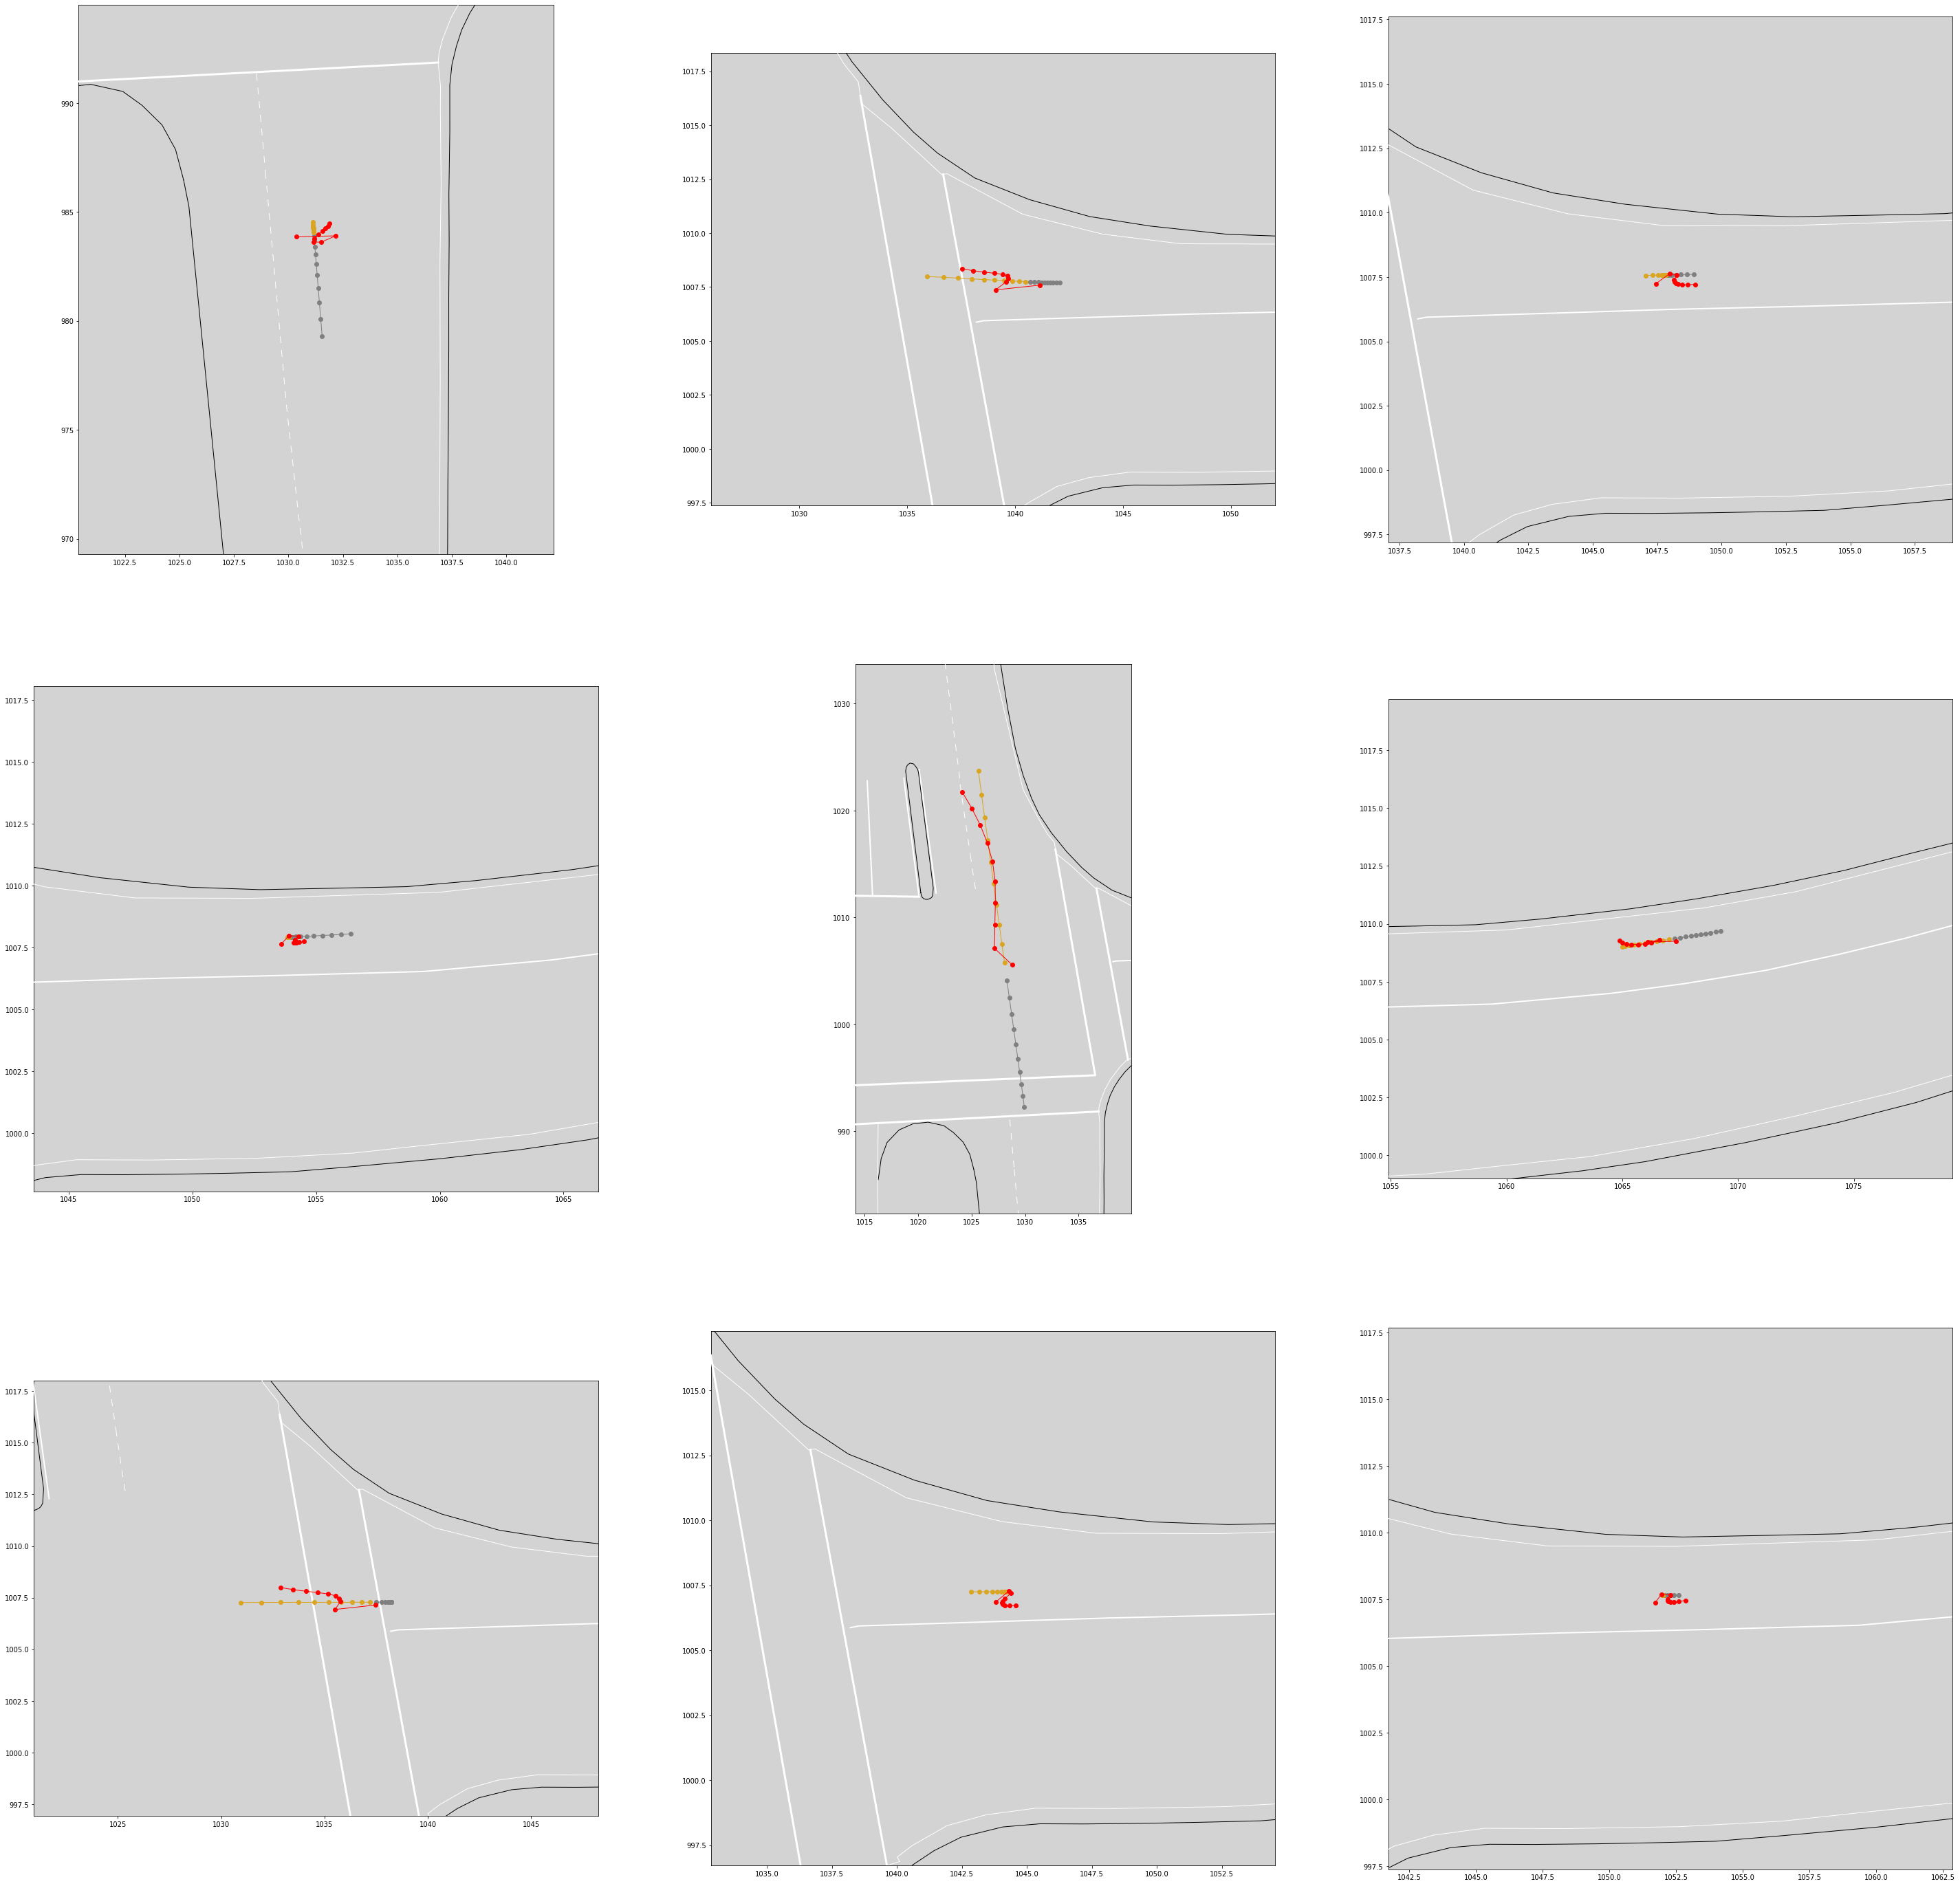

In [ ]:
print_trajectory_set(x_test[:,:,:], y_test[:,:,:], results[:,:,:],0,show_map=True, zoom_map=True,debug=False)